# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## 1. Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "traffic-signs-data/train.p"
validation_file= "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_original, y_train_original = train['features'], train['labels']
X_valid_original, y_valid_original = valid['features'], valid['labels']
X_test_original, y_test_original = test['features'], test['labels']

### 1.1 Summary of the Data Set

Statistics for the three datasets

In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train_original)

# Number of validation examples
n_validation = len(X_valid_original)

# Number of testing examples.
n_valid = len(X_valid_original)

# Number of testing examples.
n_test = len(X_test_original)

# Shape of an traffic sign image
image_shape = X_train_original[0].shape

# Unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train_original))

assert(len(X_train_original) == len(y_train_original))
assert(len(X_valid_original) == len(y_valid_original))
assert(len(X_test_original) == len(y_test_original))

print("Image Shape: {}".format(X_train_original[0].shape))
print()
print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Image Shape: (32, 32, 3)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### 1.2 Visualization of the dataset

A random image from each class is drawn on screen with its corresponding label attached as title. 


In [3]:
import csv

with open('signnames.csv') as csvFile:
    csvreader = csv.DictReader(csvFile, delimiter=',')    
    class_names = []
    for line in csvreader:
        class_names.append(line)

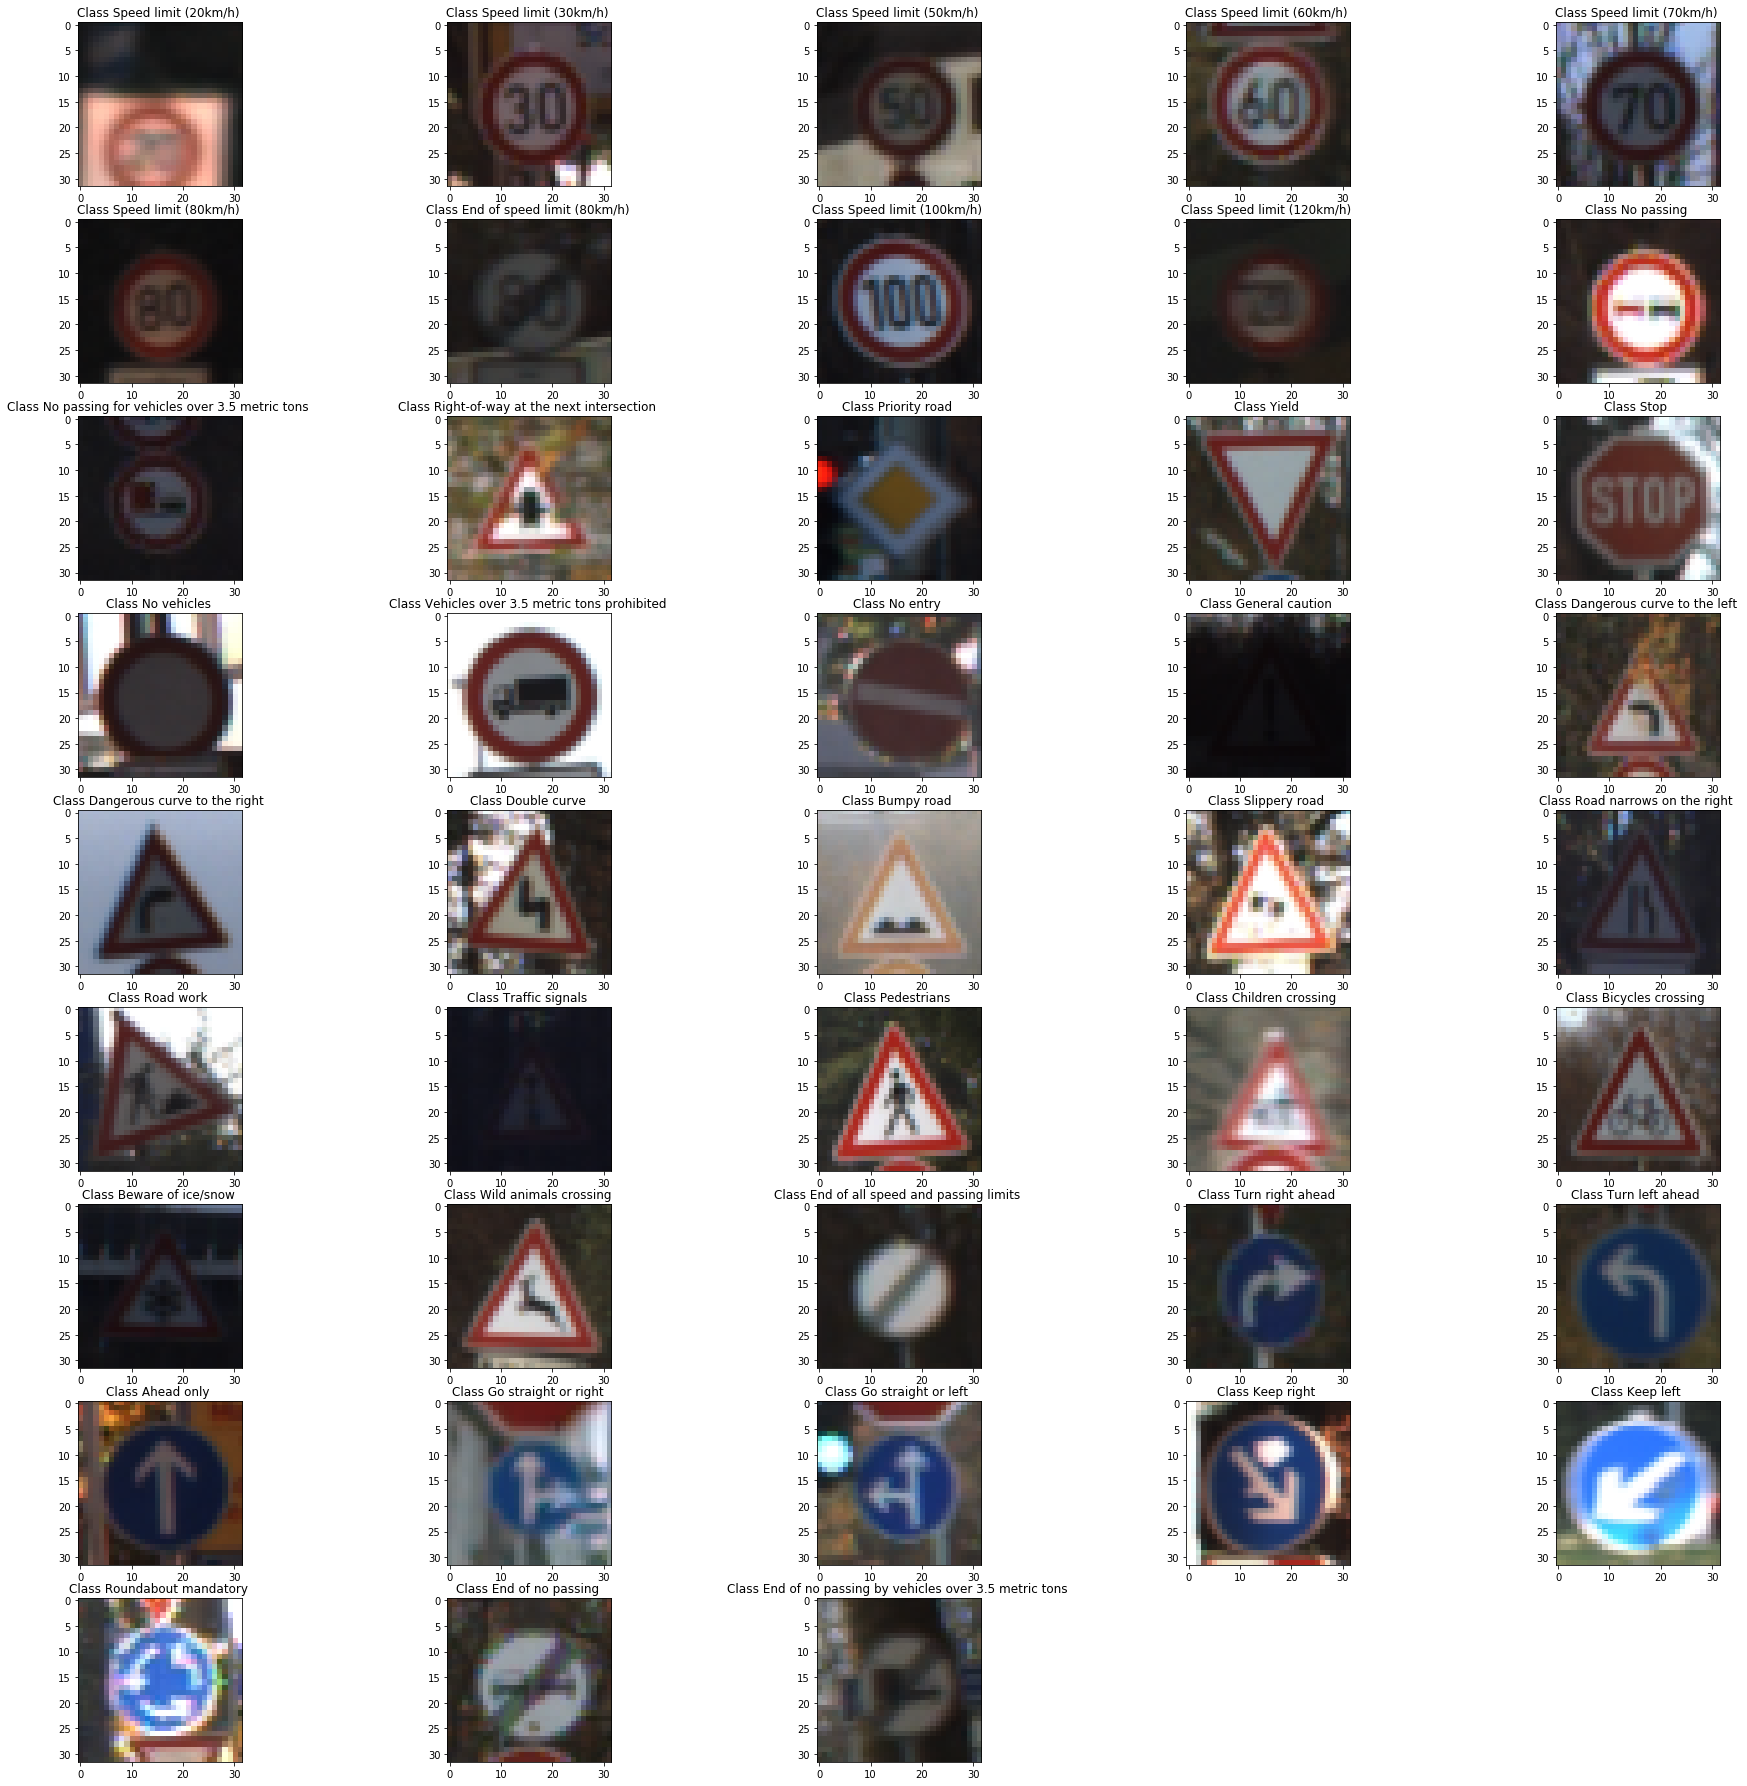

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(32, 32), tight_layout=False)
for i in range(n_classes):

    indexes_per_class = np.where(y_train_original==i)
    index = random.randint(0, len(indexes_per_class[0])-1)
    
    img = X_train_original[indexes_per_class[0][index]]
    ax = fig.add_subplot(int(n_classes/5)+1,5,i+1) 
    ax.imshow(img, interpolation='none')
    ax.set_title('Class %s ' % class_names[i].get('SignName'))
plt.savefig('output_images/test_img_thumb.png', dpi=300, format='png', bbox_inches='tight')    
plt.show()

A histogram depicting the class distribution per label is presented below

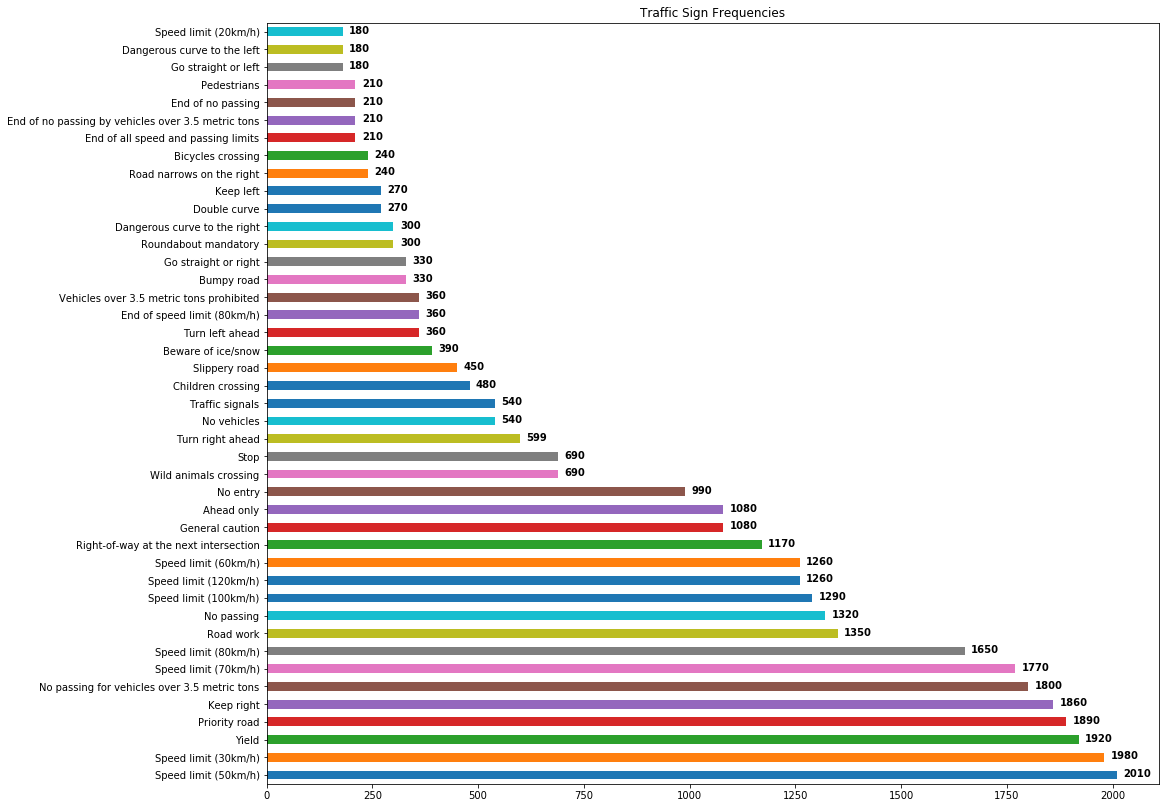

In [5]:
import pandas as pd
import os
fig, ax1 = plt.subplots()

y_train_dataFrame = pd.DataFrame()
y_train_dataFrame['labels'] = y_train_original


y_train_dataFrame['labels'].value_counts().plot(kind='barh', ax=ax1,figsize=(16, 14), title='Traffic Sign Frequencies')

ax1.set_yticklabels(list(map(lambda x: class_names[x].get('SignName'), y_train_dataFrame['labels'].value_counts().index.tolist()))) 
for i, v in enumerate(y_train_dataFrame['labels'].value_counts()):
    ax1.text(v + 15, i -0.1, str(v), fontweight='bold')

plt.savefig('output_images/class_freq.png', dpi=300, format='png', bbox_inches='tight')    

----

## 2. Model Architecture Design and Test 


The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson was used as a starting point with minor modifications. The number of classes was changed from 10 to 43. Additional `scope` labels where added in order to use Tensor Board for better visualization of the network and being able to better visualize the effect of the various parameter changes have on the trainned model. 

The initial validation accuracy, of the LeNet-5 model was about 0.89, using the initial dataset. Augmenting and normalizing the data increased the validation accuracy to 0.93. The optimizer was also changed from SGD to Adam and various learning rates were tested. The optimal rate was found to be 0.0015. With this optimizer and rate we were able to achieve an accuracy of 0.968 on the validation data and 0.951 on the test data.


### 2.1 Data Set Pre-processing

Initially, the image data was normalized so that the data had mean zero and equal variance. For image data, `(pixel - 128)/ 128`. Then the image data was converted to grayscale. However, the increase in the accurracy was not significant. 
Adaptive histogram equalization gave much better results and significantly more consistent.

In [6]:
import os
import warnings
from skimage import exposure

def normalize_images(image_data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return np.array([exposure.equalize_adapthist(img, clip_limit=0.03) for img in image_data])
                                

In [7]:
### Data pre-processing
from sklearn.utils import shuffle
import cv2

def preprocess_dataset(x):
    gray_xs = []
    for img in x:
        gray_x = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray_x = gray_x.reshape(32,32,1)
        gray_x = gray_x.astype('float32')
        gray_x = (gray_x-128.)/128
        gray_xs.append(gray_x)
    return gray_xs

X_train_gray = preprocess_dataset(X_train_original)
X_valid_gray = preprocess_dataset(X_valid_original)
X_test_gray = preprocess_dataset(X_test_original)

In [8]:
normalized_data_file = 'output_images/normalized_data.p'
normalized_data = {}

if not os.path.isfile(normalized_data_file):
    print('Normalizing Training Images.')
    X_train_normalized = normalize_images(X_train_original)
    
    print('\nNormalizing Validation Images.')
    X_valid_normalized = normalize_images(X_valid_original)
    
    print('\nNormalizing Test Images.')
    X_test_normalized = normalize_images(X_test_original)
    
    normalized_data['X_train_normalized'] = X_train_normalized
    normalized_data['X_valid_normalized'] = X_valid_normalized
    normalized_data['X_test_normalized'] = X_test_normalized
    normalized_data['y_train_original'] = y_train_original
    normalized_data['y_valid_original'] = y_valid_original
    normalized_data['y_test_original'] = y_test_original
else:
    print('Using existing project data.')


Using existing project data.


In [9]:
import pickle

if not os.path.isfile(normalized_data_file):
    print('Caching normalized data in a  pickle file.')
    try:
        with open(normalized_data_file, 'wb') as f:
            pickle.dump(normalized_data, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save normalized data to file', normalized_data_file, ':', e)
        raise
    print('Normalized data saved in pickle file.')
else:
    print('Pickle file containing normalized data exists')


Pickle file containing normalized data exists


In [10]:
import pickle

normalized_data_file = 'output_images/normalized_data.p'

with open(normalized_data_file, mode='rb') as f:
    normalized_data = pickle.load(f)
    
X_train_normalized, y_train_original = normalized_data['X_train_normalized'], normalized_data['y_train_original']
X_valid_normalized, y_valid_original = normalized_data['X_valid_normalized'], normalized_data['y_valid_original']
X_test_normalized, y_test_original = normalized_data['X_test_normalized'], normalized_data['y_test_original']
del normalized_data

In [11]:
import keras
from keras.preprocessing.image import ImageDataGenerator

datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    horizontal_flip=False,
    vertical_flip=False
)

Using TensorFlow backend.


In [12]:
import os
import numpy as np
from sklearn.utils import shuffle

augmented_data_file = 'output_images/augmented_data.p'
augmented_data = {}
total_image_per_class = 5000
X_train_augmented = np.empty((0,32,32,3))
y_train_augmented = np.empty(0,dtype='uint8')

if not os.path.isfile(augmented_data_file):
    print('Augmenting Image Data.')
    for i in range(n_classes):
        index = [y_train_original==i]
        images_for_i_class = X_train_normalized[y_train_original==i]
        y_i_class = y_train_original[y_train_original==i]
        
        X_train_augmented_i = np.copy(images_for_i_class)
        y_train_augmented_i = np.copy(y_i_class)
        
        for X,y in datagen.flow(images_for_i_class, y_i_class, batch_size=len(y_i_class), seed=9345+i*37):            
            X_train_augmented_i = np.append(X_train_augmented_i, X, axis=0)
            y_train_augmented_i = np.append(y_train_augmented_i, y, axis=0)
            
            if len(X_train_augmented_i) >= total_image_per_class:
                break

        X_train_augmented = np.append(X_train_augmented, X_train_augmented_i[:5000], axis=0)
        y_train_augmented = np.append(y_train_augmented, y_train_augmented_i[:5000], axis=0)              
else:
    print('Pickle file found.')

X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented, random_state=9345)

X_train_augmented = X_train_augmented.astype('float32')
augmented_data['X_train_augmented'] = X_train_augmented
augmented_data['y_train_augmented'] = y_train_augmented

Pickle file found.


In [13]:
import pickle

if not os.path.isfile(augmented_data_file):
    print('Caching augmented data in a  pickle file.')
    try:
        with open(augmented_data_file, 'wb') as f:
            pickle.dump(augmented_data, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save augmented data to file', augmented_data_file, ':', e)
        raise
    print('Augmented data saved in pickle file.')
else:
    print('Pickle file containing augmented data exists')


Pickle file containing augmented data exists


In [14]:
import pickle

augmented_data_file = 'output_images/augmented_data.p'

with open(augmented_data_file, mode='rb') as f:
    augmented_data = pickle.load(f)
    
X_train_augmented, y_train_augmented = augmented_data['X_train_augmented'], augmented_data['y_train_augmented']

del augmented_data

In [15]:
print("Number of training examples =", len(X_train_augmented))

Number of training examples = 215000


### Model Architecture

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson was used as a starting point with minor modifications.

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [16]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import numpy as np

from tensorflow.contrib.layers import flatten

mu = 0
sigma = 0.1
n_classes = len(np.unique(y_train_original))

In [17]:
tf.reset_default_graph()
sess = tf.Session()
###x = tf.placeholder(tf.float32, [None, 32, 32, 3], name="x")
x = tf.placeholder(tf.float32, [None, 32,32, 3], name="x")
#x_image = tf.reshape(x, [-1, 32, 32, 3])
#tf.summary.image('input', x, 3)
y = tf.placeholder(tf.int32, (None), name="labels")
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

In [18]:
def maxpool2d(x, k=2, padding='VALID'):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding=padding)

def conv_layer(input, size_in, size_out, strides=1, pad='VALID', name="conv"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([5, 5, size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="VALID")
        act = tf.nn.relu(conv + b)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return tf.nn.max_pool(act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=pad)

def fc_layer(input, size_in, size_out, name="fc"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        act = tf.matmul(input, w) + b
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return act

def LeNet(x):    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1 = conv_layer(x, 3, 6, pad='VALID', name="conv1")#
    # Activation.
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    #conv1 = maxpool2d(conv1, k=2, padding='VALID')#
    #conv1 = tf.nn.dropout(conv1, keep_prob)
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv_layer(conv1, 6, 16, pad='VALID', name="conv2")
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    #conv2 = maxpool2d(conv2, k=2, padding='VALID')
    #Flatten. Input = 5x5x16. Output = 400.
    fc0 = tf.reshape(conv2, [-1, 400])
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = fc_layer(fc0, 400, 120, name="fc1")
    # Activation.
    fc1 = tf.nn.relu(fc1)
    tf.summary.histogram("fc1/relu", fc1)
    #Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = fc_layer(fc1, 120, 84, name="fc2")
    # Activation.
    fc2 = tf.nn.relu(fc2)
    tf.summary.histogram("fc2/relu", fc2)
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = fc_layer(fc2, 84, n_classes, name="out")
    return logits


In [19]:
EPOCHS = 10
BATCH_SIZE = 128
rate = 0.0015
beta = 5e-4
start_learn_rate = 0.0015
batch = tf.Variable(0)
train_size = y_train_augmented.shape[0]

logits = LeNet(x)
with tf.name_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    # L2 loss
    #regularizers = (tf.nn.l2_loss(weights['wc1']) + tf.nn.l2_loss(weights['wc2']) + tf.nn.l2_loss(weights['wd1']) + tf.nn.l2_loss(weights['wd2']) + tf.nn.l2_loss(weights['out']))
    loss_operation = tf.reduce_mean(cross_entropy )
    loss_operation = loss_operation #+ (beta * regularizers)
    tf.summary.scalar("loss", loss_operation)
    
    learning_rate = tf.train.exponential_decay(
      start_learn_rate,    # Base learning rate.
      batch * BATCH_SIZE,  # Current index into the dataset.
      train_size,          # Decay step.
      0.96,                # Decay rate.
      staircase=True)
    
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [20]:
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy_operation)

summ = tf.summary.merge_all()
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [21]:
from sklearn.utils import shuffle
import time

#A name for the Tensor Board summaries
name = "traffic-sign-classifier-{}".format(int(time.time()))
LOGDIR = "/home/joseppi/udacity/graphs/"

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(LOGDIR + name)
    writer.add_graph(sess.graph)
    num_examples = len(X_train_augmented)
    print(num_examples)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train_augmented, y_train_augmented)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
           #writer.add_summary(s, i)
        trainning_accuracy = evaluate(X_train_augmented, y_train_augmented)
        validation_accuracy = evaluate(X_valid_normalized, y_valid_original)
        print("EPOCH {} ...".format(i+1))
        print("Trainning Accuracy = {:.3f}".format(trainning_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

215000
Training...

EPOCH 1 ...
Trainning Accuracy = 0.900
Validation Accuracy = 0.889

EPOCH 2 ...
Trainning Accuracy = 0.945
Validation Accuracy = 0.930

EPOCH 3 ...
Trainning Accuracy = 0.970
Validation Accuracy = 0.951

EPOCH 4 ...
Trainning Accuracy = 0.965
Validation Accuracy = 0.923

EPOCH 5 ...
Trainning Accuracy = 0.979
Validation Accuracy = 0.946

EPOCH 6 ...
Trainning Accuracy = 0.986
Validation Accuracy = 0.951

EPOCH 7 ...
Trainning Accuracy = 0.986
Validation Accuracy = 0.945

EPOCH 8 ...
Trainning Accuracy = 0.985
Validation Accuracy = 0.939

EPOCH 9 ...
Trainning Accuracy = 0.984
Validation Accuracy = 0.947

EPOCH 10 ...
Trainning Accuracy = 0.991
Validation Accuracy = 0.949

Model saved


In [22]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_normalized, y_test_original)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.934


---

## 3. Testing the Model on New Images

Ten images from the Belgian traffic sign set were downloaded, as they are pretty similar to the German traffic signs. These are reference images i.e. not taken The class names were taken from `signnames.csv` as it contains mappings from the class id (integer) to the actual sign name.

### 3.1 Loading and displaying Images

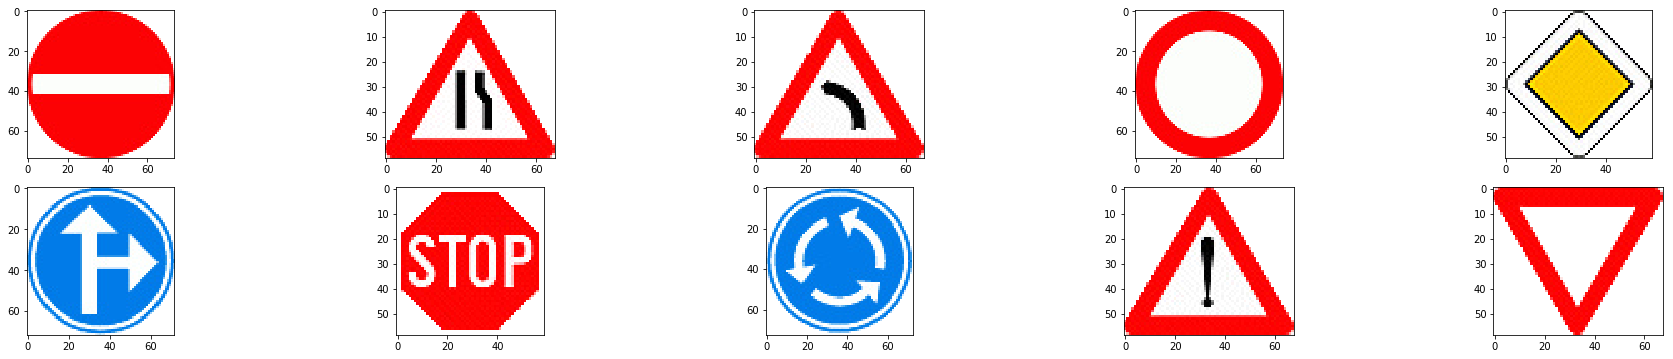

In [23]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

images = glob.glob('data/signs/*.png')
fig = plt.figure(figsize=(32,32), tight_layout=False)

for  k, img in enumerate(images):
    image = mpimg.imread(img)
    #print(image.shape)
    ax = fig.add_subplot(len(images),5,k+1) 
    ax.imshow(image)
plt.savefig('output_images/test_signs.png', dpi=300, format='png', bbox_inches='tight')    

### 3.2 Sign Type prediction for Each Image

INFO:tensorflow:Restoring parameters from ./lenet


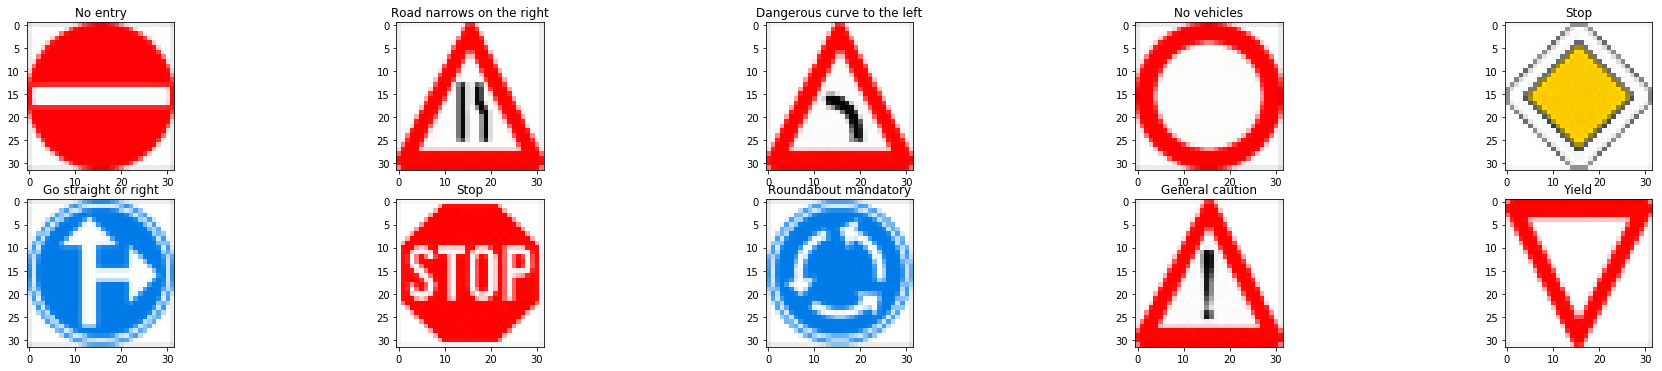

In [24]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
from skimage.transform import resize
import tensorflow as tf

images = glob.glob('data/signs/*.png')
fig = plt.figure(figsize=(32,32), tight_layout=False)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess = tf.get_default_session()
    for  k, img in enumerate(images):
        image = mpimg.imread(img)
        image_resized = resize(image, (32, 32), anti_aliasing=True, mode='constant')
        image_normalized= normalize_images(np.array([np.array(image_resized)]))
        imgd=image_normalized.reshape(1,image_resized.shape[0],image_resized.shape[1],image_resized.shape[2])
        logit = sess.run(tf.argmax(logits, 1), feed_dict={x: imgd, keep_prob:1})
        ax = fig.add_subplot(len(images),5,k+1)
        ax.imshow(image_resized)
        ax.set_title(class_names[logit[0]].get('SignName'))
plt.savefig('output_images/classified_test_signs.png', dpi=300, format='png', bbox_inches='tight')    
        

A second set of images, taken from actual pictures was also used to test the classification accuracy when real world image are used. These traffic signs were from a French traffic sign set.

INFO:tensorflow:Restoring parameters from ./lenet


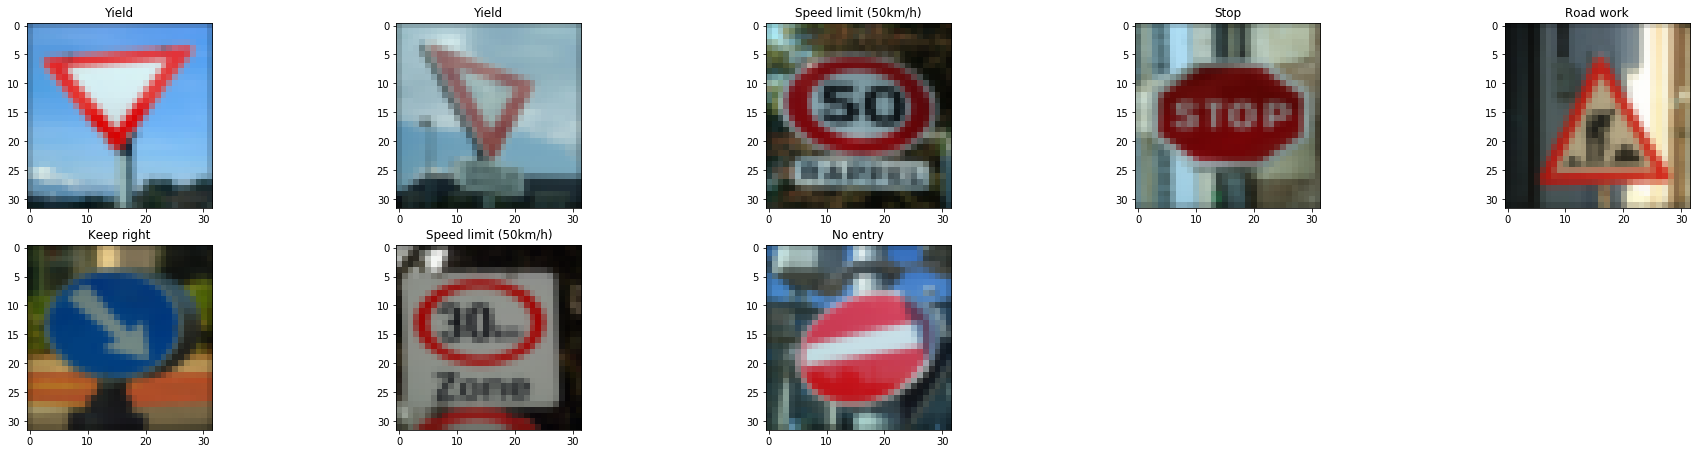

In [25]:
from skimage.transform import resize
import tensorflow as tf

images = glob.glob('data/signs/*.jpg')
fig = plt.figure(figsize=(32,32), tight_layout=False)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess = tf.get_default_session()
    for  k, img in enumerate(images):
        image = mpimg.imread(img)
        image_resized = resize(image, (32, 32), anti_aliasing=True, mode='constant')
        image_normalized= normalize_images(np.array([np.array(image_resized)]))
        imgd=image_normalized.reshape(1,image_resized.shape[0],image_resized.shape[1],image_resized.shape[2])
        logit = sess.run(tf.argmax(logits, 1), feed_dict={x: imgd, keep_prob:1})
        ax = fig.add_subplot(len(images),5,k+1)
        ax.imshow(image_resized)
        ax.set_title(class_names[logit[0]].get('SignName'))
plt.savefig('output_images/classified_test_signs_french.png', dpi=300, format='png', bbox_inches='tight')    
  

Some of the images are missclassified, but that may be attributed to the fact that these signs were somehow different from the ones used for testing (German - French signs).

### 3.3 Performance analysis

INFO:tensorflow:Restoring parameters from ./lenet


<Figure size 1080x144 with 0 Axes>

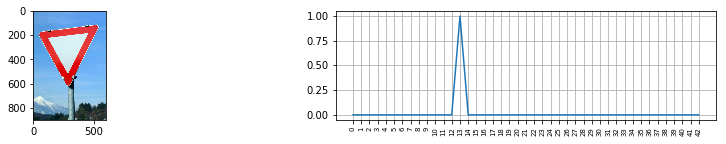

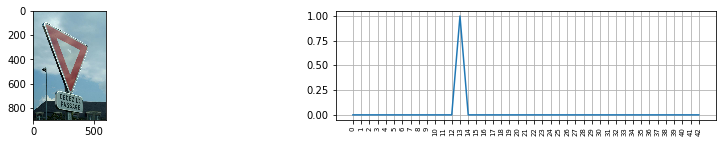

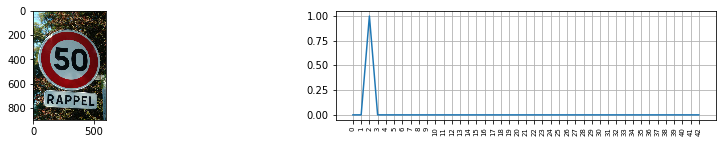

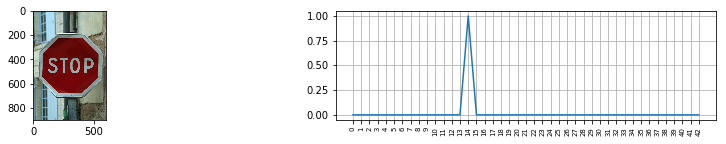

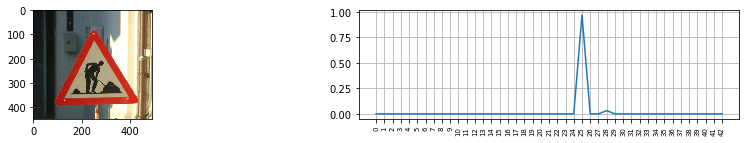

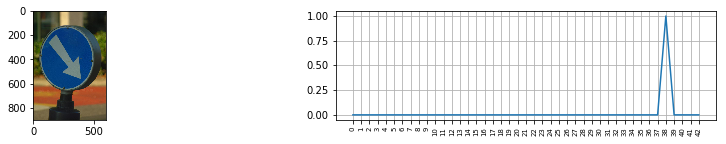

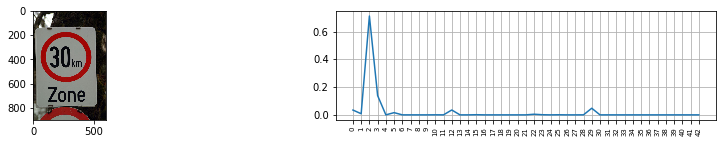

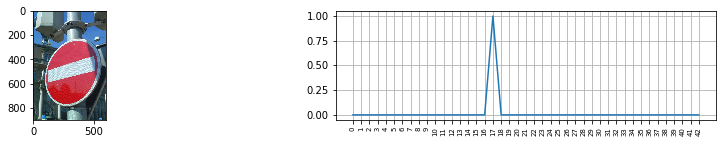

In [72]:
### Accuracy calculation for the previous 8 images. 
import glob
import matplotlib.pyplot as plt
from skimage.transform import resize
import tensorflow as tf

images = glob.glob('data/signs/*.jpg')
fig = plt.figure(figsize=(15,2))

softmax = None
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess = tf.get_default_session()
    for  k, img in enumerate(images):
        image = mpimg.imread(img)
        image_resized = resize(image, (32, 32), anti_aliasing=True, mode='constant')
        image_normalized= normalize_images(np.array([np.array(image_resized)]))
        imgd=image_normalized.reshape(1,image_resized.shape[0],image_resized.shape[1],image_resized.shape[2])
        softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: imgd, keep_prob:1})
        fig = plt.figure(figsize=(15,2))
        ax = fig.add_subplot(1,2,1) 
        ax.imshow(image)

        ax = fig.add_subplot(1,2,2) 
        ax.set_xticks(np.arange(0,43,1))
        plt.plot(softmax[0])
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize('x-small') 
            tick.label.set_rotation('vertical')
        plt.grid()
        plt.show()

### 3.4 Top 3 Softmax Probabilities for test images

For each of the real world images we print the top 3 softmax probabilities and the predicted class


In [73]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
import collections, numpy

images = glob.glob('data/signs/*.jpg')

softmax = None
predictions = 0

actual_labels = np.array([13, 13, 2, 14, 25, 38, 1, 17])
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess = tf.get_default_session()
    for  k, img in enumerate(images):
        image = mpimg.imread(img)
        image_resized = resize(image, (32, 32), anti_aliasing=True, mode='constant')
        image_normalized= normalize_images(np.array([np.array(image_resized)]))
        imgd=image_normalized.reshape(1,image_resized.shape[0],image_resized.shape[1],image_resized.shape[2])
        
        softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: imgd, keep_prob:1})
        TopKV2 = sess.run(tf.nn.top_k(tf.constant(softmax), k=3))
        prediction = tf.argmax(softmax, 1).eval()
        print("These are the top 3 probabilities {} ".format(TopKV2[0]))
        print("This is the prediction {}".format(prediction))

        if prediction == actual_labels[k]:
            predictions = predictions +1
            print('Succeeded in classifing sign')
        else:
            print('Failed in classifing sign')
            
    acc = predictions/len(actual_labels)
    print("Actual real world accuracy: {} %".format(acc))

INFO:tensorflow:Restoring parameters from ./lenet
These are the top 3 probabilities [[1.0000000e+00 1.0110184e-18 2.4435804e-20]] 
This is the prediction [13]
Succeeded in classifing sign
These are the top 3 probabilities [[1.0000000e+00 8.1317237e-09 7.4942595e-15]] 
This is the prediction [13]
Succeeded in classifing sign
These are the top 3 probabilities [[9.9986672e-01 8.9392546e-05 4.2266740e-05]] 
This is the prediction [2]
Succeeded in classifing sign
These are the top 3 probabilities [[1.0000000e+00 4.5645404e-08 1.8204133e-08]] 
This is the prediction [14]
Succeeded in classifing sign
These are the top 3 probabilities [[9.6830744e-01 3.1443667e-02 2.2819974e-04]] 
This is the prediction [25]
Succeeded in classifing sign
These are the top 3 probabilities [[1.0000000e+00 3.1545079e-11 1.3011395e-12]] 
This is the prediction [38]
Succeeded in classifing sign
These are the top 3 probabilities [[0.7119442  0.13864112 0.04765041]] 
This is the prediction [2]
Failed in classifing sig

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.